<a href="https://colab.research.google.com/github/google/tunix/blob/main/examples/qlora_demo.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary libraries

In [1]:
!pip install -q kagglehub

!pip install -q tensorflow
!pip install -q tensorboardX
!pip install -q grain
!pip install -q jax==0.6.2 jaxlib==0.6.2
# !pip install -q git+https://github.com/google/tunix
! pip install -q ~/tunix/
!pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
!pip install -q git+https://github.com/google/flax.git@5d5c907d1b5f45c97138289d5aa2e2e8452bf52e


!pip install -q tensorflow-datasets

!pip install -q git+https://github.com/AI-Hypercomputer/pathways-utils.git



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip



In [2]:
# # If you want to upload your metrics to Weights & Biases, please install the package and login. Make sure to install `wandb` before importing `tunix`.
# !pip install wandb

# import wandb
# wandb.login()

If `wandb` is installed, you'll see a message like the one below when you start the experiment:

```
Tracking run with wandb version 0.21.0
Run data is saved locally in /content/wandb/run-20250717_224322-kmvoi0ho
Syncing run 2025-07-17_22-43-22 to Weights & Biases (docs)
View project at https://wandb.ai/<wandb_username>/tunix?apiKey=<api_key>
View run at https://wandb.ai/<wandb_username>/tunix/runs/kmvoi0ho?apiKey=<api_key>
Do NOT share these links with anyone. They can be used to claim your runs.
```

After clicking the link, you will be directed to the following Weights & Biases metrics page which contain train metrics, eval metrics, system metrics, and various custom metric you wish to report:

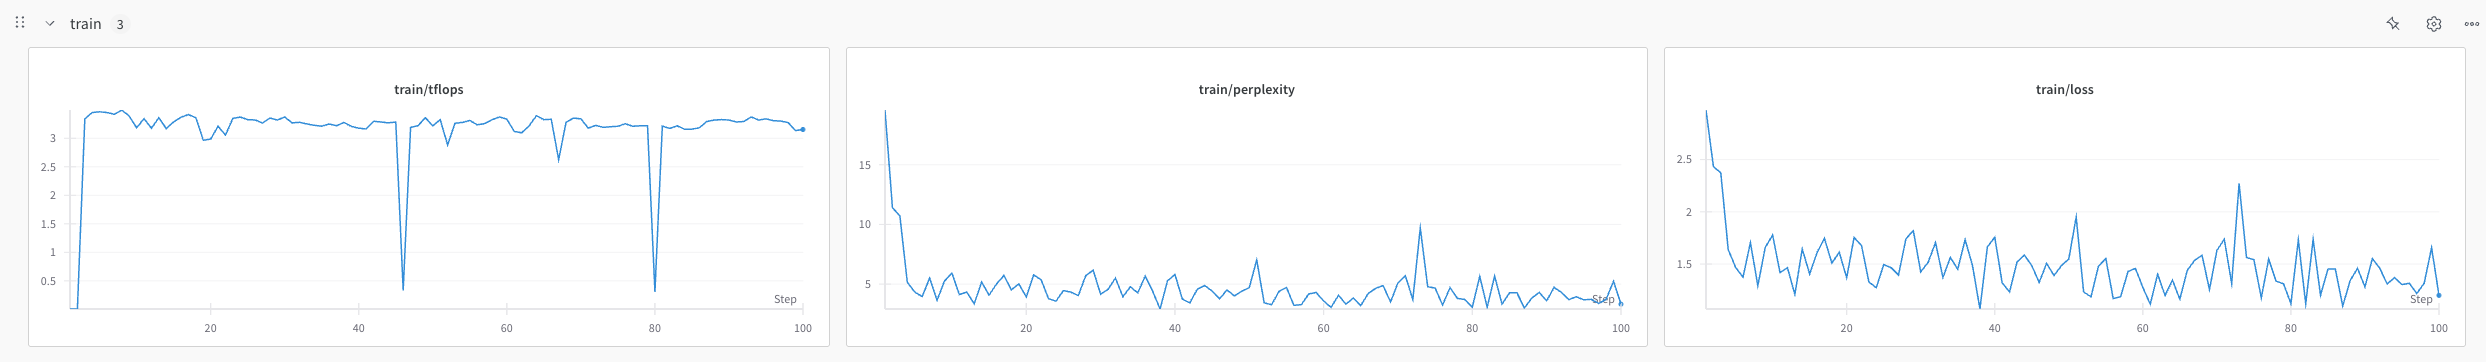

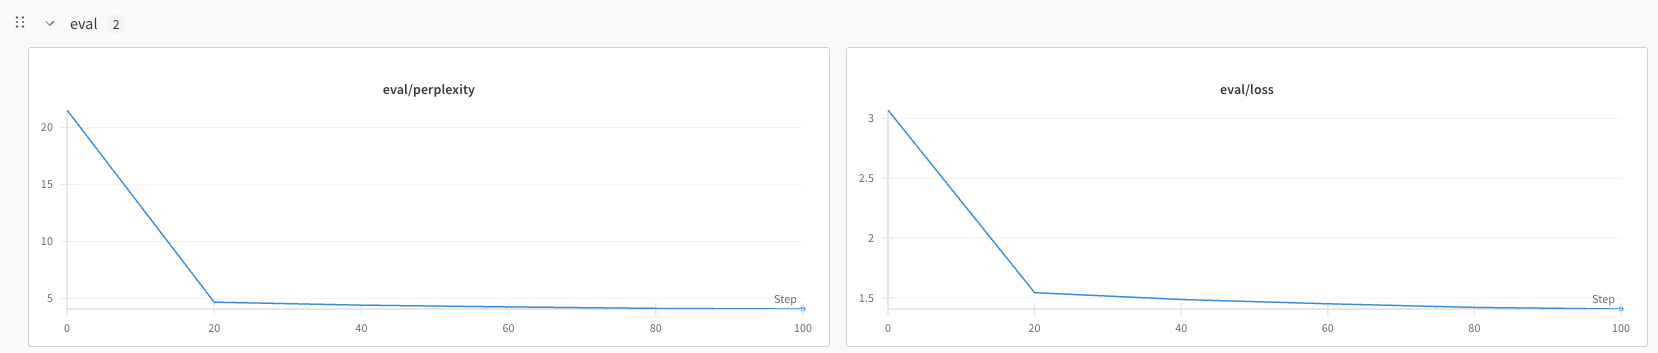

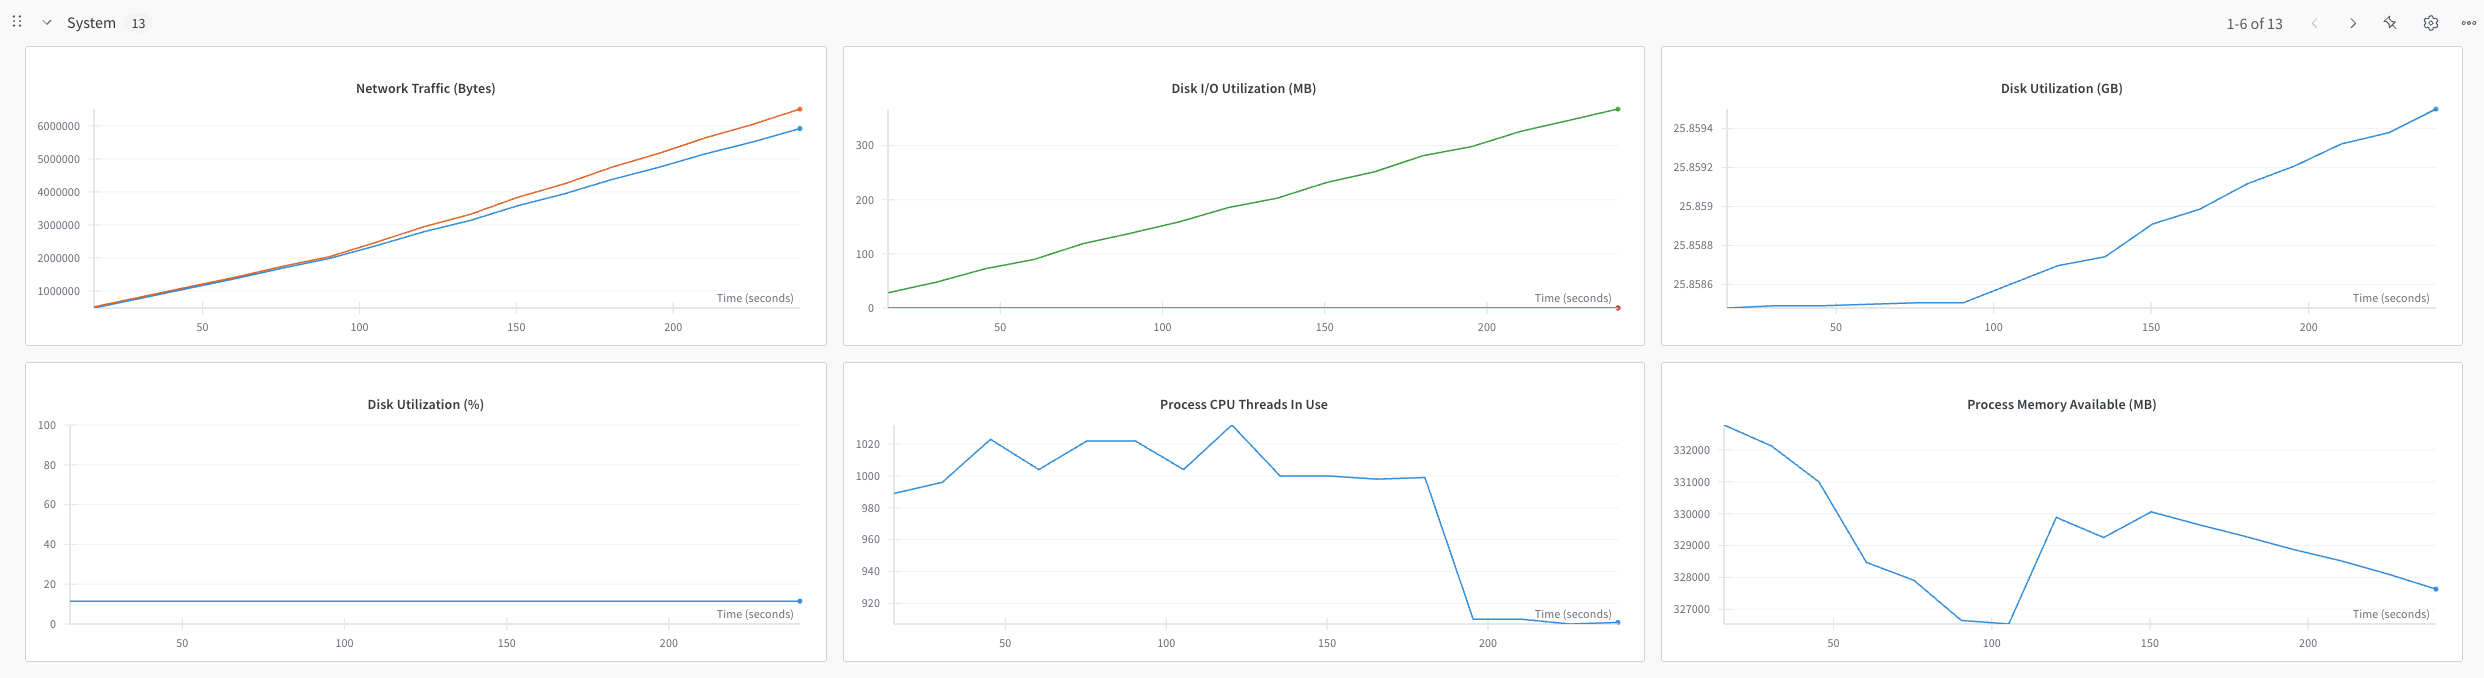

In [3]:
!pip install tensorflow-datasets
!pip install aqtp
!pip install pillow>=11.1.0
!pip install pillow
!pip install omegaconf
!pip install google-cloud-storage


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install tensorflow_text transformers tiktoken


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Imports

In [5]:
import gc
import os
import time

from flax import nnx
import os

# Set the TPU library path in the environment
os.environ['TPU_LIBRARY_PATH'] = '/home/mazumdera_google_com/.local/lib/python3.10/site-packages/libtpu/libtpu.so'

import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
from qwix import lora
from tunix.generate import sampler as sampler_lib
from tunix.models.gemma import data as data_lib
from tunix.models.gemma import gemma as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.sft import metrics_logger
from tunix.sft import peft_trainer

/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/jax/__init__.py:31: UserWarning: cloud_tpu_init failed: AttributeError("module 'libtpu' has no attribute 'get_library_path'")
 This a JAX bug; please report an issue at https://github.com/jax-ml/jax/issues
  _warn(f"cloud_tpu_init failed: {exc!r}\n This a JAX bug; please report "


## Hyperparameters

In [6]:
# Data
BATCH_SIZE = 16

# Model
MESH = [(1, 8), ("fsdp", "tp")]
# LoRA
RANK = 16
ALPHA = 2.0

# Train
MAX_STEPS = 100
EVAL_EVERY_N_STEPS = 20
NUM_EPOCHS = 3


# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "~/qlora_expt/content/intermediate_ckpt/"
CKPT_DIR = "~/qlora_expt/content/ckpts/"
PROFILING_DIR = "~/qlora_expt/content/profiling/"

## Load Gemma 2B

To load the model, you need to be on [Kaggle](https://www.kaggle.com/) and need
to have agreed to the Gemma license
[here](https://www.kaggle.com/models/google/gemma/flax/).

In [7]:
# Log in
# if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
  # kagglehub.login()


In [8]:
kaggle_ckpt_path = kagglehub.model_download("google/gemma/flax/2b")

In [9]:
# # This is a workaround. The checkpoints on Kaggle don't work with NNX. So, we
# # load the model, save the checkpoint locally, and then reload the model
# # (sharded).
# params = params_lib.load_and_format_params(os.path.join(kaggle_ckpt_path, "2b"))
# gemma = gemma_lib.Transformer.from_params(params, version="2b")
# checkpointer = ocp.StandardCheckpointer()
# _, state = nnx.split(gemma)
# checkpointer.save(os.path.join(INTERMEDIATE_CKPT_DIR, "state"), state)

In [10]:
# # # Wait for the ckpt to save successfully.
# time.sleep(60)

In [11]:
# # Delete the intermediate model to save memory.
# del params
# del gemma
# del state
# gc.collect()

In [12]:
import sys
import os

# add the parent directory (one level up) to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../maxtext')))

# ! pip install -r ../../maxtext/requirements.txt

import MaxText as mt
from MaxText import pyconfig

2025-08-07 05:02:57.089721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754542977.102620 2310310 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754542977.106387 2310310 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754542977.117537 2310310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754542977.117551 2310310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754542977.117552 2310310 computation_placer.cc:177] computation placer alr

ImportError: cannot import name 'Pytree' from 'flax.nnx' (/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/flax/nnx/__init__.py)

In [ ]:
# from MaxText.integration.tunix.tunix_adaptor import TunixMaxTextLlama
from flax import linen as nn
import orbax.checkpoint as ocp

  #python3 -m MaxText.train MaxText/configs/base.yml base_output_directory=${BASE_OUTPUT_DIRECTORY} dataset_path=${DATASET_PATH} tokenizer_path=assets/tokenizer.gemma load_parameters_path=${CONVERTED_CHECKPOINT} per_device_batch_size=1 run_name=${FINETUNE_RUN_NAME} max_target_length=8192 steps=10 async_checkpointing=false model_name=gemma-2b checkpoint_period=5

#TODO: @mazumdera: change this to use Gemma2-2b-it
config = pyconfig.initialize(
    ["", "../../maxtext/MaxText/configs/base.yml"], #TODO: @mazumdera: why decode.py?
    base_output_directory="gs://dummy_output_dir",  # This is not used in Tunix.
    run_name="test-tunix-maxtext-llama3-8b",
    # dataset_path=we use Tunix's dataset
    # load_parameters_path="gs://maxtext-gemma/2b/", #TODO: @mazumdera: change this to use checkpoint
    # tokenizer_type="tiktoken",
    # tokenizer_path="assets/tokenizer_llama3.tiktoken",
    tokenizer_path="../../maxtext/assets/tokenizer.gemma",
    per_device_batch_size=8,
    max_target_length=8192,
    steps=10,
    async_checkpointing="false",
    # model_name="llama3.1-8b",
    model_name="gemma-2b",
    checkpoint_period=5,
    skip_jax_distributed_system="true",
    weight_dtype="bfloat16",
    attention="dot_product"

)

Updating keys from env and command line: ['run_name', 'model_name', 'async_checkpointing', 'checkpoint_period', 'weight_dtype', 'attention', 'base_output_directory', 'tokenizer_path', 'per_device_batch_size', 'steps', 'skip_jax_distributed_system', 'max_target_length']
Running Model: gemma-2b
Updating following parameters in config

base_emb_dim: 2048
base_num_query_heads: 8
base_num_kv_heads: 1
base_mlp_dim: 16384
base_num_decoder_layers: 18
head_dim: 256
mlp_activations: ['gelu', 'linear']
vocab_size: 256128
decoder_block: gemma
normalization_layer_epsilon: 1e-06
logits_via_embedding: True
Updating keys from model: ['base_emb_dim', 'base_num_query_heads', 'base_num_kv_heads', 'base_mlp_dim', 'base_num_decoder_layers', 'head_dim', 'mlp_activations', 'vocab_size', 'decoder_block', 'normalization_layer_epsilon', 'logits_via_embedding']
Skipping jax distributed system due to skip_jax_distributed_system=True flag.
Not using emergency checkpoint, ignoring local_checkpoint_directory, local_

In [ ]:
def load_params_from_path(
    load_parameters_from_path, abstract_unboxed_params, checkpoint_storage_concurrent_gb, use_ocdbt=True, use_zarr3=True
):
  """Load decode params from checkpoint at specified path."""
  assert load_parameters_from_path, "load_parameters_from_path is not defined."
  max_logging.log(f"restoring params from {load_parameters_from_path}")

  # *_concurrent_gb should be set for large models, the default is 96.
  max_logging.log(f"Creating checkpoint manager with ocdbt={use_ocdbt} and zarr3={use_zarr3}")
  ckptr = ocp.Checkpointer(
      ocp.PyTreeCheckpointHandler(
          restore_concurrent_gb=checkpoint_storage_concurrent_gb,
          save_concurrent_gb=checkpoint_storage_concurrent_gb,
          use_ocdbt=use_ocdbt,
          use_zarr3=use_zarr3,
      )
  )
  max_logging.log("Checkpoint manager created!")
  # This is a memory optimization. We don't want to restore the entire checkpoint - only the params.
  # Rather than pass the entire abstract state, which could unnecessarily restore opt_state and such and waste
  # memory, we instead specify here that we are just restoring the params field of the checkpoint
  # (which itself may be a dictionary containing a key named 'params').
  restore_args = ocp.checkpoint_utils.construct_restore_args(abstract_unboxed_params)
  restored = ckptr.restore(
      epath.Path(load_parameters_from_path),
      item={"params": abstract_unboxed_params},
      transforms={},
      restore_args={"params": restore_args},
  )
  print(f"{restored=}")
  return restored["params"]

In [ ]:
from MaxText import max_logging
from etils import epath

def create_model(config):
    return mt.from_pretrained(config, rngs=nnx.Rngs(params=0, dropout=1))

abstract_model = nnx.eval_shape(create_model, config=config)
graphdef, abstract_state = nnx.split(abstract_model)
print('The abstract NNX state (all leaves are abstract arrays):')
nnx.display(abstract_state)
  
# state_restored = mt.checkpointing.load_params_from_path(
#     load_parameters_from_path="gs://maxtext-gemma/2b/2025-08-05-04-37/0/items",
#     abstract_unboxed_params=abstract_state,
#     checkpoint_storage_concurrent_gb=None,
# )
# state_restored = checkpointer

state_restored = load_params_from_path(
    load_parameters_from_path="gs://maxtext-gemma/2b/2025-08-05-04-37/0/items",
    abstract_unboxed_params=abstract_state,
    checkpoint_storage_concurrent_gb=None,
)



print(f"{state_restored=}")
model = nnx.merge(graphdef, state_restored)

model.decoder.layers["mlp"]["wi_0"]["kernel"]
  

Num_devices: 8, shape (1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1)
The abstract NNX state (all leaves are abstract arrays):


restoring params from gs://maxtext-gemma/2b/2025-08-05-04-37/0/items
Creating checkpoint manager with ocdbt=True and zarr3=True
Checkpoint manager created!


restored={'params': State({
  'decoder': {
    'decoder_norm': {
      'scale': Param( # 2,048 (4.1 KB)
        value=ShapeDtypeStruct(shape=(2048,), dtype=bfloat16),
        mesh=None,
        sharding=('norm',),
        sharding_rules=None,
        linen_meta_type=LogicallyPartitioned
      )
    },
    'layers': {
      'mlp': {
        'wi_0': {
          'kernel': Param( # 603,979,776 (1.2 GB)
            value=ShapeDtypeStruct(shape=(2048, 18, 16384), dtype=bfloat16),
            mesh=None,
            sharding=('embed', 'layers', 'mlp'),
            sharding_rules=None,
            linen_meta_type=LogicallyPartitioned
          )
        },
        'wi_1': {
          'kernel': Param( # 603,979,776 (1.2 GB)
            value=ShapeDtypeStruct(shape=(2048, 18, 16384), dtype=bfloat16),
            mesh=None,
            sharding=('embed', 'layers', 'mlp'),
            sharding_rules=None,
            linen_meta_type=LogicallyPartitioned
          )
        },
        'wo': {
      

Param( # 603,979,776 (1.2 GB)
  value=ShapeDtypeStruct(shape=(2048, 18, 16384), dtype=bfloat16),
  mesh=None,
  sharding=('embed', 'layers', 'mlp'),
  sharding_rules=None,
  linen_meta_type=LogicallyPartitioned
)

: 

In [ ]:
# from MaxText.integration.tunix.tunix_adaptor import TunixMaxTextLlama
from flax import linen as nn

def get_ref_maxtext_model():

  #python3 -m MaxText.train MaxText/configs/base.yml base_output_directory=${BASE_OUTPUT_DIRECTORY} dataset_path=${DATASET_PATH} tokenizer_path=assets/tokenizer.gemma load_parameters_path=${CONVERTED_CHECKPOINT} per_device_batch_size=1 run_name=${FINETUNE_RUN_NAME} max_target_length=8192 steps=10 async_checkpointing=false model_name=gemma-2b checkpoint_period=5

  #TODO: @mazumdera: change this to use Gemma2-2b-it
  config = pyconfig.initialize(
      ["", "../../maxtext/MaxText/configs/base.yml"], #TODO: @mazumdera: why decode.py?
      base_output_directory="gs://dummy_output_dir",  # This is not used in Tunix.
      run_name="test-tunix-maxtext-llama3-8b",
      # dataset_path=we use Tunix's dataset
      # load_parameters_path="gs://maxtext-gemma/2b/", #TODO: @mazumdera: change this to use checkpoint
      # tokenizer_type="tiktoken",
      # tokenizer_path="assets/tokenizer_llama3.tiktoken",
      tokenizer_path="../../maxtext/assets/tokenizer.gemma",
      per_device_batch_size=8,
      max_target_length=8192,
      steps=10,
      async_checkpointing="false",
      # model_name="llama3.1-8b",
      model_name="gemma-2b",
      checkpoint_period=5,
      skip_jax_distributed_system="true",
      weight_dtype="bfloat16",
      attention="dot_product"

  )
  
  def create_model(config):
    return mt.from_pretrained(config, rngs=nnx.Rngs(params=0, dropout=1))

  model = nnx.eval_shape(create_model, config=config)

  abstract_model = nnx.eval_shape(create_model, config=config)
  graphdef, abstract_state = nnx.split(abstract_model)
  print('The abstract NNX state (all leaves are abstract arrays):')
  nnx.display(abstract_state)
  checkpoint = mt.checkpointing.load_params_from_path(
      load_parameters_from_path="gs://maxtext-gemma/2b/2025-08-05-04-37/0/items",
      abstract_unboxed_params=None,
      checkpoint_storage_concurrent_gb=None,
  )
  print("{checkpoint=}")
  # checkpoint = {}

  @nnx.jit
  def partial_init(checkpoint, config):
    model = create_model(config)
    nnx.update(model, checkpoint)
    # shard model
    state = nnx.state(model)
    specs = nnx.get_partition_spec(state)
    state = jax.lax.with_sharding_constraint(state, specs)
    nnx.update(model, state)
    return model

  with jax.sharding.use_mesh(model.mesh), nn.logical_axis_rules(config.logical_axis_rules):
    model = partial_init(checkpoint, config)
  print(model)

  
  tunix_model = TunixMaxTextLlama(
        base_model=model,
        use_attention_mask=False,  # trust Tunix loss masking
    )
  mesh  = tunix_model.base.mesh
  
  #TODO: @mazumdera: change this to use llama3.1-8b
  # model_config = None
  # We can continue to use Tunix's model_config
  model_config = gemma_lib.TransformerConfig.gemma2_2b()

  # Add these lines to properly get the graph definition and state
  graphdef, state = nnx.split(tunix_model)
  tunix_model = nnx.merge(graphdef, state)  # Recreate model in proper NNX format
    
  
  return tunix_model, mesh, model_config

In [ ]:
# Base model
# gemma, mesh, model_config = get_base_model(
#     ckpt_path=os.path.join(INTERMEDIATE_CKPT_DIR, "state")
# )

gemma, mesh, model_config = get_ref_maxtext_model()
# gemma_maxtext_nnx = nnx.bridge.ToNNX(gemma)
# Instead of:
nnx.display(gemma)

# Use:
print("Model initialized successfully")
print(f"Model mesh shape: {mesh.shape}")
print(f"Model config: {model_config}")

Updating keys from env and command line: ['run_name', 'model_name', 'async_checkpointing', 'checkpoint_period', 'weight_dtype', 'attention', 'base_output_directory', 'tokenizer_path', 'per_device_batch_size', 'steps', 'skip_jax_distributed_system', 'max_target_length']
Running Model: gemma-2b
Updating following parameters in config

base_emb_dim: 2048
base_num_query_heads: 8
base_num_kv_heads: 1
base_mlp_dim: 16384
base_num_decoder_layers: 18
head_dim: 256
mlp_activations: ['gelu', 'linear']
vocab_size: 256128
decoder_block: gemma
normalization_layer_epsilon: 1e-06
logits_via_embedding: True
Updating keys from model: ['base_emb_dim', 'base_num_query_heads', 'base_num_kv_heads', 'base_mlp_dim', 'base_num_decoder_layers', 'head_dim', 'mlp_activations', 'vocab_size', 'decoder_block', 'normalization_layer_epsilon', 'logits_via_embedding']
Skipping jax distributed system due to skip_jax_distributed_system=True flag.
Not using emergency checkpoint, ignoring local_checkpoint_directory, local_

Config param tokenize_eval_data: True
Config param tokenize_train_data: True
Config param tokenizer_path: ../../maxtext/assets/tokenizer.gemma
Config param tokenizer_type: sentencepiece
Config param topk_routing_group: -1
Config param train_data_columns: ['text']
Config param train_image_column: image
Config param train_split: train
Config param trainable_position_size: -1
Config param upload_all_profiler_results: False
Config param use_chat_template: False
Config param use_chunked_prefill: False
Config param use_dpo: False
Config param use_iota_embed: False
Config param use_multimodal: False
Config param use_post_attn_norm: False
Config param use_post_ffw_norm: False
Config param use_qk_norm: False
Config param use_ragged_attention: False
Config param use_random_routing: False
Config param use_replicator_service: False
Config param use_sft: False
Config param use_untrainable_positional_embedding: False
Config param use_vertex_tensorboard: False
Config param using_pipeline_parallelism:

restoring params from gs://maxtext-gemma/2b/2025-08-05-04-37/0/items
Creating checkpoint manager with ocdbt=True and zarr3=True
Checkpoint manager created!


{checkpoint=}
Num_devices: 8, shape (1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1)


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
gemma.base.decoder.layers["mlp"]["wi_0"]["kernel"]

Param( # 603,979,776 (1.2 GB)
  value=Array([[[-0.0349121, 0.019043, 0.0178223, ..., -0.00424194, 0.0116577,
           -0.00518799],
          [-0.0373535, 0.0285645, -0.00473022, ..., 0.0314941, -0.0172119,
           0],
          [0.0032959, 0.0111694, 0.00762939, ..., 0.0314941, -0.0148926,
           -0.0196533],
          ...,
          [0.00714111, -0.046875, 0.0305176, ..., 0.0444336, 0.00376892,
           -0.00909424],
          [0.00714111, 0.00811768, 0.00518799, ..., -0.00376892,
           0.00665283, -0.000938416],
          [-0.0373535, -0.0324707, -0.000469208, ..., -0.046875,
           0.00860596, 0.00424194]],
  
         [[0.0154419, -0.0148926, -0.0373535, ..., 0.00473022, 0.0216064,
           -0.0373535],
          [-0.00909424, -0.0245361, 0.0405273, ..., 0.00282288, -0.012207,
           -0.000469208],
          [0.0361328, -0.000938416, -0.02771, ..., 0.0196533, -0.00616455,
           0.0159912],
          ...,
          [0.0116577, -0.0216064, -0.00234985,

In [ ]:
import jax.numpy as jnp
import os
# I'm assuming you have these imports in your script.
# If not, you'll need to add them.
# from tunix.models.gemma import gemma as gemma_lib
# from path.to import data_lib

TEMP_BATCH_SIZE = 8

# Assuming gemma is a pre-loaded instance of gemma_lib.Transformer
# and data_lib is available.
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

tokens = gemma_tokenizer.encode("Translate this into French:\nHello, my name is Morgane.\n")
# tokens.append(jnp.repeat(jnp.array([gemma_tokenizer.eos_id()]),2048-len(tokens),axis=0))  
# tokens = [gemma_tokenizer.bos_id()]+gemma_tokenizer.encode("The color of the sky is blue but")

repeated_tokens = jnp.repeat(jnp.array(tokens)[None, :], TEMP_BATCH_SIZE, axis=0)
positions = jnp.repeat(jnp.arange(0, len(tokens))[None, :], TEMP_BATCH_SIZE, axis=0)

# --- FIX STARTS HERE ---

# The Gemma model requires an attention mask. Passing `None` causes an error.
# We need to create a causal attention mask for the prefill step.

# 1. Create a boolean mask for the input tokens (True for valid tokens, False for padding).
#    Assuming `gemma_tokenizer.pad_id()` exists. If not, and there's no padding,
#    `jnp.ones_like(repeated_tokens, dtype=jnp.bool_)` would also work.
#    A common pad_id is 0.
pad_id = gemma_tokenizer.pad_id()
input_mask = (repeated_tokens != pad_id)

# 2. Create a causal attention mask from the input mask.
#    This prevents the model from attending to future tokens.
attention_mask = gemma_lib.make_causal_attn_mask(input_mask)

# 3. Call the model with the correct attention mask.
gemma_output_logits, _ = gemma(repeated_tokens, positions, cache=None, attention_mask=attention_mask)  # Test the model to ensure it works

# --- FIX ENDS HERE ---

# The commented out line below would also need a proper attention_mask.
# For example:
# dummy_tokens = jnp.ones((TEMP_BATCH_SIZE, 16), jnp.int32)
# dummy_positions = jnp.repeat(jnp.arange(0,16)[None,:], TEMP_BATCH_SIZE, axis=0)
# dummy_mask = gemma_lib.make_causal_attn_mask(jnp.ones_like(dummy_tokens, dtype=jnp.bool_))
# gemma_output = gemma(dummy_tokens, dummy_positions, cache=None, attention_mask=dummy_mask)

print("Successfully ran the model!")
print("Output shape:", gemma_output_logits.shape)

print(f"Tokens: {tokens}")
print(f"positions: {positions}")


attn_mask=[[[[[ 0.0000000e+00 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38]
    [ 0.0000000e+00  0.0000000e+00 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38]
    [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38]
    [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38 -2.3819763e+38
     -2.3819763e+38 -2.3819763e+38 -2.3819763e+38]
    [ 

inputs=[[[-0.976562 6.21875 2.90625 ... -2.8125 3.14062 1.25781]
  [-1.64844 3.625 -0.259766 ... 2.21875 -1.57812 -0.213867]
  [1.01562 3.95312 -2.4375 ... -2.125 -2.39062 0.929688]
  ...
  [3.57812 0.988281 2.03125 ... 0.460938 2.25 -0.318359]
  [-0.738281 1.67188 -0.212891 ... 1.29688 0.667969 0.542969]
  [-1.08594 1.78125 1.03125 ... -1.92969 0.792969 -4.34375]]

 [[-0.976562 6.21875 2.90625 ... -2.8125 3.14062 1.25781]
  [-1.64844 3.625 -0.259766 ... 2.21875 -1.57812 -0.213867]
  [1.01562 3.95312 -2.4375 ... -2.125 -2.39062 0.929688]
  ...
  [3.57812 0.988281 2.03125 ... 0.460938 2.25 -0.318359]
  [-0.738281 1.67188 -0.212891 ... 1.29688 0.667969 0.542969]
  [-1.08594 1.78125 1.03125 ... -1.92969 0.792969 -4.34375]]

 [[-0.976562 6.21875 2.90625 ... -2.8125 3.14062 1.25781]
  [-1.64844 3.625 -0.259766 ... 2.21875 -1.57812 -0.213867]
  [1.01562 3.95312 -2.4375 ... -2.125 -2.39062 0.929688]
  ...
  [3.57812 0.988281 2.03125 ... 0.460938 2.25 -0.318359]
  [-0.738281 1.67188 -0.212891 

In [ ]:
gemma

TunixMaxTextLlama( # Param: 2,506,434,560 (5.0 GB), RngState: 4 (24 B), Total: 2,506,434,564 (5.0 GB)
  base=TransformerNNX( # Param: 2,506,434,560 (5.0 GB), RngState: 4 (24 B), Total: 2,506,434,564 (5.0 GB)
    config=<MaxText.pyconfig.HyperParameters object at 0x758fa28d97d0>,
    decoder=ToNNX( # Param: 1,981,884,416 (4.0 GB), RngState: 4 (24 B), Total: 1,981,884,420 (4.0 GB)
      decoder_norm={'scale': Param( # 2,048 (4.1 KB)
        value=Array(shape=(2048,), dtype=dtype(bfloat16)),
        mesh=None,
        sharding=('norm',),
        sharding_rules=None,
        linen_meta_type=LogicallyPartitioned
      )},
      layers={'mlp': {'wi_0': {'kernel': Param( # 603,979,776 (1.2 GB)
        value=Array(shape=(2048, 18, 16384), dtype=dtype(bfloat16)),
        mesh=None,
        sharding=('embed', 'layers', 'mlp'),
        sharding_rules=None,
        linen_meta_type=LogicallyPartitioned
      )}, 'wi_1': {'kernel': Param( # 603,979,776 (1.2 GB)
        value=Array(shape=(2048, 18, 1

In [ ]:
print(gemma_output_logits.shape)
jnp.argmax(gemma_output_logits, axis=2)  

(8, 15, 256128)


Array([[ 49688,    736,   1280,   6987, 235292,    108,   4521, 235269,
           970,   1503,    603,  20189, 235249, 235265,    108],
       [ 49688,    736,   1280,   6987, 235292,    108,   4521, 235269,
           970,   1503,    603,  20189, 235249, 235265,    108],
       [ 49688,    736,   1280,   6987, 235292,    108,   4521, 235269,
           970,   1503,    603,  20189, 235249, 235265,    108],
       [ 49688,    736,   1280,   6987, 235292,    108,   4521, 235269,
           970,   1503,    603,  20189, 235249, 235265,    108],
       [ 49688,    736,   1280,   6987, 235292,    108,   4521, 235269,
           970,   1503,    603,  20189, 235249, 235265,    108],
       [ 49688,    736,   1280,   6987, 235292,    108,   4521, 235269,
           970,   1503,    603,  20189, 235249, 235265,    108],
       [ 49688,    736,   1280,   6987, 235292,    108,   4521, 235269,
           970,   1503,    603,  20189, 235249, 235265,    108],
       [ 49688,    736,   1280,   6987, 2

In [ ]:
last_token_logits = gemma_output_logits[:, -1, :]
predicted_token_id = jnp.argmax(last_token_logits, axis=-1)
# Decode the token ID to see the predicted word.
# Since TEMP_BATCH_SIZE is 1, we can just grab the first element.
next_token_id = predicted_token_id[0]
predicted_token_text = gemma_tokenizer.decode([int(next_token_id)])

print(f"\nPredicted next token ID: {next_token_id}")
print(f"Predicted next token: '{predicted_token_text}'")


Predicted next token ID: 108
Predicted next token: '
'


In [ ]:
gemma_output_logits[0][0,7]

Array(0.85546875, dtype=float32)

In [ ]:
# def get_base_model(ckpt_path):

#   model_config = gemma_lib.TransformerConfig.gemma_2b()
#   mesh = jax.make_mesh(*MESH)
#   abs_gemma: nnx.Module = nnx.eval_shape(
#       lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
#   )
#   abs_state = nnx.state(abs_gemma)
#   abs_state = jax.tree.map(
#       lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
#       abs_state,
#       nnx.get_named_sharding(abs_state, mesh),
#   )
#   checkpointer = ocp.StandardCheckpointer()
#   restored_params = checkpointer.restore(ckpt_path, target=abs_state)

#   graph_def, _ = nnx.split(abs_gemma)
#   gemma = nnx.merge(graph_def, restored_params)
#   return gemma, mesh, model_config

## Prompt the model

Let's see how the model performs on the English-French translation task.

In [ ]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

from MaxText.input_pipeline import _input_pipeline_utils
from MaxText.globals import PKG_DIR

# gemma_tokenizer = _input_pipeline_utils.get_tokenizer(
#         os.path.join(os.path.dirname(PKG_DIR), "assets", "tokenizer_llama3.tiktoken"),
#         "tiktoken",
#         add_bos=True,
#         add_eos=False,
#     )
#     )
# gemma_tokenizer = data_lib.GemmaTokenizer(
# )

sampler = sampler_lib.Sampler(
    transformer=gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "The color of the sky is \n",
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
    echo=True,  # Whether to echo the input string in the output.
)

for input_string, out_string, tokens in zip(input_batch, out_data.text, out_data.tokens):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")
  print(f"Tokens:\n{tokens}")

inputs=[[[1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  ...
  [0.539062 -0.333984 0.123047 ... -0.439453 -0.796875 2.51562]
  [-1.03125 -0.621094 -0.292969 ... -0.271484 0.8125 0.785156]
  [-0.132812 -1 -0.292969 ... -0.192383 1.01562 1.28125]]

 [[-0.550781 1.32812 0.304688 ... -0.691406 0.921875 -1.73438]
  [0.0245361 1.15625 0.515625 ... 0.472656 1.04688 1.625]
  [-1 1.24219 -1.83594 ... 1.19531 -0.824219 -0.132812]
  ...
  [0.472656 0.261719 -0.0146484 ... -0.171875 2.01562 0.65625]
  [0.5625 0.632812 -0.292969 ... 2.51562 -0.333984 0.123047]
  [-0.132812 -1 -0.292969 ... -0.192383 1.01562 1.28125]]

 [[1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  ...
  [-0.0344238 0.103027 0.494141 ... -1.65625 -0.152344 -0

In [ ]:
gemma_tokenizer.encode("The color\n")
gemma_tokenizer.decode([235336    , 108 ])

'?\n'

In [ ]:
sampler.transformer_state

State({
  'base': {
    'decoder': {
      'decoder_norm': {
        'scale': Param( # 2,048 (4.1 KB)
          value=Array([1, 1, 1, ..., 1, 1, 1], dtype=bfloat16),
          mesh=None,
          sharding=('norm',),
          sharding_rules=None,
          linen_meta_type=LogicallyPartitioned
        )
      },
      'layers': {
        'mlp': {
          'wi_0': {
            'kernel': Param( # 603,979,776 (1.2 GB)
              value=Array([[[-0.0349121, 0.019165, 0.0178223, ..., -0.00421143, 0.0117188,
                       -0.00521851],
                      [-0.0375977, 0.0284424, -0.00469971, ..., 0.0314941, -0.017334,
                       0],
                      [0.0032196, 0.0111694, 0.00750732, ..., 0.0314941, -0.0148315,
                       -0.0197754],
                      ...,
                      [0.00723267, -0.046875, 0.0303955, ..., 0.0441895, 0.00370789,
                       -0.0090332],
                      [0.00723267, 0.00799561, 0.00521851, ..., -0.00

## Apply LoRA/QLoRA to the model

In [ ]:
def get_lora_model(base_model, mesh):
  lora_provider = lora.LoraProvider(
      module_path=".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj",
      rank=RANK,
      alpha=ALPHA,
      # comment the two args below for LoRA (w/o quantisation).
      weight_qtype="nf4",
      tile_size=256,
  )

  model_input = base_model.get_model_input()
  lora_model = lora.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [ ]:
# # LoRA model
# lora_gemma = get_lora_model(gemma, mesh=mesh)
# nnx.display(lora_gemma)

## Load Datasets for SFT Training

In [ ]:
# Loads the training and validation datasets
train_ds, validation_ds = data_lib.create_datasets(
    dataset_name='mtnt/en-fr',
    # Uncomment the line below to use a Hugging Face dataset.
    # Note that this requires upgrading the 'datasets' package and restarting
    # the Colab runtime.
    # dataset_name='Helsinki-NLP/opus-100',
    global_batch_size=BATCH_SIZE,
    max_target_length=256,
    num_train_epochs=NUM_EPOCHS,
    tokenizer=gemma_tokenizer,
)


def gen_model_input_fn(x: peft_trainer.TrainingInput):
  pad_mask = x.input_tokens != gemma_tokenizer.pad_id()
  positions = gemma_lib.build_positions_from_mask(pad_mask)
  attention_mask = gemma_lib.make_causal_attn_mask(pad_mask)
  return {
      'input_tokens': x.input_tokens,
      'input_mask': x.input_mask,
      'positions': positions,
      'attention_mask': attention_mask,
  }

## SFT Training

### Training with full weights

In [ ]:
logging_option = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/tensorboard/full", flush_every_n_steps=20
)
training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    metrics_logging_options=logging_option,
)
trainer = peft_trainer.PeftTrainer(gemma, optax.adamw(1e-5), training_config)
trainer = trainer.with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "full_training")):
  with mesh:
    trainer.train(train_ds, validation_ds)

wandb: Currently logged in as: anony-mouse-863749125460230603 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ValueError: Resource axis: norm of PartitionSpec('norm',) is not found in mesh: ('data', 'stage', 'fsdp', 'fsdp_transpose', 'sequence', 'context', 'context_autoregressive', 'tensor', 'tensor_transpose', 'tensor_sequence', 'expert', 'autoregressive').

### Training with LoRA/QLoRA

In [ ]:
# Restart Colab runtime.

training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    checkpoint_root_directory=CKPT_DIR,
)
lora_trainer = peft_trainer.PeftTrainer(
    lora_gemma, optax.adamw(1e-3), training_config
).with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "peft")):
  with mesh:
    lora_trainer.train(train_ds, validation_ds)

### Compare profile results of different training

<font size=3>Setup<font>           | <font size=3>Train Step Time<font> | <font size=3>Peak Memory Usage<font>
---------------------------------- | ---------------------------------- | ------------------------------
<font size=3>Full weights<font>        |   <font size=3>~1.22 s<font>     |   <font size=3>43.26 GiB<font>
<font size=3>QLoRA<font>        |   <font size=3>~1.19 s<font>     |   <font size=3>28.14 GiB<font>

## Generate with the LoRA/QLoRA model

The QLoRA model still cannot do English-to-French translation properly since we
only trained for 100 steps. If you train it for longer, you will see better
results.

In [ ]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

sampler = sampler_lib.Sampler(
    transformer=lora_gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")